In [1]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter , lfilter
from scipy.fftpack import fft, fftfreq
%matplotlib inline

from scipy import signal

In [2]:
'''  MODEL PARAMETERS '''

Cm = 100*pF                    # membrane capacitance
g_leak =10*nS                  # leak conductance
E_rest = -65*mvolt             # membrane rest potential
V_thresh = -52*mvolt           # membrane threshold potential
V_reset = -67*mvolt            # membrane reset potential 
tau_m = 10*ms                  # membrane time constant
tau_r = 1*ms                   # absolute refractory period

E_i  = -75*mvolt               # inhib. reversal potential
E_e  =  0*mvolt                # excit. reversal potential

tau_l = 1*ms                   # time delay 
tau_r_e  = 0.5*ms
tau_d_e  = 2*ms
tau_r_i  = 0.45*ms
tau_d_i  = 1.2*ms

g_peak_e = 1*nS
g_peak_i = 5*nS


N_inhib = 200      # number of inhibitory inter neurons in the network
N_excit = 800      # each inter neuron gets input from 800 excit. neurons.

In [3]:
def heaviside(t , t0):
    if t >= t0:
        return 1
    else:
        return 0  

# Check timecourse of conductance for a single neuron

In [4]:
defaultclock.dt = 0.05*ms             # choose a particular time step
timestep = 0.05*ms
input_rate = (5000/N_excit)*Hz       # total input to each neuron is 5 KHz
alpha = 20 /ms

''' ----------  NEURON EQUATIONS ------------- '''

eqs_model = '''
dv/dt = (g_leak*(E_rest - v) + I_syn )/Cm : volt
I_syn = I_ampa_exc + I_rec : amp
I_ampa_exc = g_peak_e*(E_e - v)*s_ampa_tot : amp
I_rec = g_peak_i*(E_i -v)*s_rec_tot : amp
s_ampa_tot : 1
s_rec_tot  : 1
'''

eqs_ampa = '''
s_ampa_tot_post = w * s_ampa : 1 (summed)
ds_ampa / dt = - s_ampa / tau_d_e + alpha * x * (1 - s_ampa) : 1 (clock-driven)
dx / dt = - x / tau_r_e : 1 (clock-driven)
w : 1
'''
eqs_pre_ampa = '''
x += 1
'''
eqs_rec = '''
s_rec_tot_post = w * s_rec : 1 (summed)
ds_rec / dt = - s_rec / tau_d_i + alpha * y * (1 - s_rec) : 1 (clock-driven)
dy / dt = - y / tau_r_i : 1 (clock-driven)
w : 1
'''
eqs_pre_rec = '''
y += 1
'''

indices = array([0,0,0])
times  = array([50 , 100, 150])*ms
SGG = SpikeGeneratorGroup(1 , indices, times)
G = NeuronGroup(N_inhib, eqs_model, threshold='v> V_thresh', reset='v = V_reset', method ='euler')

# Excitatory Synapse Group
S_excit = Synapses(SGG,G, model=eqs_ampa , on_pre= eqs_pre_ampa , delay = tau_l , method = 'euler')
S_excit.connect(i = 0, j = 10)
S_excit.w = 1.0
# Inhibitory, Recurrent Synapse Group

S_inhib = Synapses(G,G,model=eqs_rec , on_pre= eqs_pre_rec , delay = tau_l , method = 'euler')
S_inhib.connect(condition='i!=j', p=0.2)
# set inhib weights to 1.0 as well
S_inhib.w = 1.0
# Spike, State Monitors

State_Mon = StateMonitor(G, variables = ['v', 's_ampa_tot' ] , record = True)
#Spike_Mon = SpikeMonitor(G)
#Rate_Mon = PopulationRateMonitor(G)

# initialise at rest 
G.v = E_rest
print('Before v = %s' % G.v[0])
run(200*ms)
print('After v = %s' % G.v[0])

/Users/martin/Library/Caches/cython/brian_extensions/_cython_magic_31e8a7e4bdfafb45720c179579b7f61d.cpp:679:14: fatal error: 'cstdlib' file not found
    #include <cstdlib>
             ^~~~~~~~~
1 error generated.
WARNING    Cannot use Cython, a test compilation failed: command 'gcc' failed with exit status 1 (CompileError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


Before v = -65. mV
After v = -65. mV


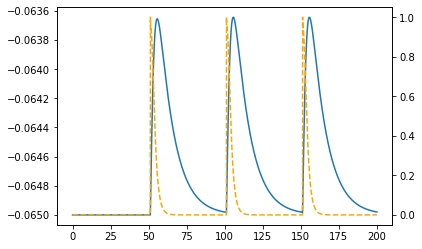

The peak synaptic conductance achievd is 1. m^-2 kg^-1 s^3 A 
Timed spike inputs were given at [ 50. 100. 150.] ms


In [5]:
fig, ax = plt.subplots()
ax.plot(State_Mon.t/ms, State_Mon.v[10]/volt)

ax1 = ax.twinx()
ax1.plot(State_Mon.t/ms, State_Mon.s_ampa_tot[10]/volt , color = 'orange' , ls = '--')
ax1.set_ylabel('')
plt.show()

print('The peak synaptic conductance achievd is %s ' % np.max(State_Mon.s_ampa_tot[10]/volt))
print('Timed spike inputs were given at %s' % times)

# Actual simulations of the Network

In [6]:
def do_simulation(sim_dur, inp_freq, tau_d_i=1.2*ms, g_peak_i=5*nS):
    defaultclock.dt = 0.05*ms             # choose a particular time step
    timestep = 0.05*ms
    input_rate = (inp_freq/N_excit)*Hz       # total input to each neuron is 5 KHz
    alpha = 20 /ms

    ''' ----------  NEURON EQUATIONS ------------- '''

    eqs_model = '''
    dv/dt = (g_leak*(E_rest - v) + I_syn )/Cm : volt
    I_syn = I_ampa_exc + I_rec : amp
    I_ampa_exc = g_peak_e*(E_e - v)*s_ampa_tot : amp
    I_rec = g_peak_i*(E_i -v)*s_rec_tot : amp
    s_ampa_tot : 1
    s_rec_tot  : 1
    '''

    eqs_ampa = '''
    s_ampa_tot_post = w * s_ampa : 1 (summed)
    ds_ampa / dt = - s_ampa / tau_d_e + alpha * x * (1 - s_ampa) : 1 (clock-driven)
    dx / dt = - x / tau_r_e : 1 (clock-driven)
    w : 1
    '''
    eqs_pre_ampa = '''
    x += 1
    '''
    eqs_rec = '''
    s_rec_tot_post = w * s_rec : 1 (summed)
    ds_rec / dt = - s_rec / tau_d_i + alpha * y * (1 - s_rec) : 1 (clock-driven)
    dy / dt = - y / tau_r_i : 1 (clock-driven)
    w : 1
    '''
    eqs_pre_rec = '''
    y += 1
    '''
    #clip(gi, 0, g_peak_i)
    P = PoissonGroup(8400, rates=input_rate)

    G = NeuronGroup(N_inhib, eqs_model, threshold='v> V_thresh', reset='v = V_reset', method ='euler')

    # Excitatory Synapse Group
    S_excit = Synapses(P,G, model=eqs_ampa , on_pre= eqs_pre_ampa , delay = tau_l , method = 'euler')
    S_excit.connect(p=0.095)
    S_excit.w = 1.0
    # Inhibitory, Recurrent Synapse Group

    S_inhib = Synapses(G,G,model=eqs_rec , on_pre= eqs_pre_rec , delay = tau_l , method = 'euler')
    S_inhib.connect(condition='i!=j', p=0.2)
    # set inhib weights to 1.0 as well
    S_inhib.w = 1.0
    # Spike, State Monitors

    State_Mon = StateMonitor(G, 'v',record=True)
    Spike_Mon = SpikeMonitor(G)
    Rate_Mon = PopulationRateMonitor(G)

    # initialise at rest 
    G.v = E_rest
    print('Before v = %s' % G.v[0])
    run(sim_dur)
    print('After v = %s' % G.v[0])
    
    return (State_Mon, Spike_Mon, Rate_Mon)

In [7]:
def isi_analysis(spike_mon):
    # Inter-Spike-Interval (ISI)
    p = 0
    for j in range(200):
       
        spike_time_temp = spike_mon.t[np.where(spike_mon.i == j)[0]]/ms

        if len(spike_time_temp) > 1 & p==0:

            p = 1
            isi_array = np.diff(spike_time_temp)

            isi_means = np.mean(np.diff(spike_time_temp))
            isi_std = np.std(np.diff(spike_time_temp))
            isi_cv = isi_std/isi_means
        
        elif len(spike_time_temp) > 1 & p==1:

            isi_array = np.hstack((isi_array,np.diff(spike_time_temp)))

            isi_means = np.append(isi_means,np.mean(np.diff(spike_time_temp)))
            isi_std = np.append(isi_std,np.std(np.diff(spike_time_temp)))
            isi_cv = np.append(isi_cv,isi_std[-1]/isi_means[-1])
                  
    return isi_array , isi_means , isi_std, isi_cv

def cvar(isi_arr,inp_freq,gaba=0):
    cv_ind = np.std(isi_arr)/np.mean(isi_arr)
    cv_out = np.hstack((cv_ind,inp_freq,gaba,len(isi_arr)))

    return  cv_out

def plotISI(spike_mon,axI):
    isi_array , isi_means , isi_std  , cv  = isi_analysis(spike_mon)
    #axI.errorbar(np.arange(len(isi_means)) , np.sort(isi_means) , yerr = isi_std, label = 'f = 10kHz')
    axI.plot(np.sort(isi_means) , label = 'mean ISI')
    axI.plot(np.sort(isi_std) , label = 'stddev of ISI')
    #axI.set_xlabel('Neuron Index')
    axI.set_xticks([])
    axI.set_ylabel('ISI (ms)')
    #axI.set_title('ISI Variability No GABA' )
    axI.set_title('sorted (seperately) ISI-statistcs of the individual neurons')
    axI.legend()

def freq_analysis(time_vec, signal):
    
    # sampling freq.
    fs = 1000/(time_vec[1] - time_vec[0]) 

    # FFT & get power spectral density
    signalFFT = fft(signal-np.mean(signal))
    signalPSD = np.abs(signalFFT) ** 2
    # only up to fs/2, don't need mirror
    half = signalPSD[0:int(len(signalPSD)/2)]

    # create frequency-vector
    f = np.arange(0, fs/2, fs/(2*len(half)))

    return (f, half)
    #''''''''''
    #
    # Is the area under the FFT normalized???
    #
    #''''''''''
    
def mean_spike(Spike_Mon, sim_time):
    spike=np.zeros(200)
    for j in range(0,200): 
        spike[j]=sum((Spike_Mon.i==j)*1)/(sim_time)
    return spike

def FFTplot(freq, signalFFT, ax):
    
    ax.plot(freq,signalFFT,'orange',label='Spectral energy')
    ax.set_xlabel("$f$ [Hz]")
    ax.set_ylabel('Spectral energy')
    ax.legend(loc=7)
    ax.set_xlim([0, 500])
    ax.set_title("Histogram individual rate & spectral energy population")
    
def plot_time(t, s, ax):
    ax.plot(t, s)
    ax.set_xlabel('ms')
    ax.set_xlim((50,100))
    ax.set_ylabel('Spikes/s')
    ax.set_title('Network Population Activity')
    
def plot_firing_raster(Spike_Mon, ax):
    ax.plot(Spike_Mon.t/ms, Spike_Mon.i , '.k')
    ax.set_xlabel('ms')
    ax.set_xlim(50,100)
    ax.set_ylabel('Neuron Index')
    ax.set_title('Network Firing Raster Plot')

def plot_firing_dist(spike, ax):
    #ax.hist(Rate_Mon.rate/Hz , bins = 20)
    #ax.set_title('Firing Frequency Distribution')
    
    ax.hist(spike,bins=20,density=True,label='Neurons Spiking rate')
    ax.set_xlim(0,500)
    ax.set_xlabel("$f$ [Hz]")
#     ax.set_xlabel('Mean individual spike rate')
    ax.set_ylabel('Fraction of neurons')
    ax.legend()
    
def plot_time_and_freq(time, signal, axT, axF):
    # plot network activity in time domain
    plot_time(time[1000:], signal[1000:], axT)
    # plot frequency-domain of network actvity
    f, sFFT = freq_analysis(time, signal)
    FFTplot(f, sFFT, axF)

def plot_all(time, signal, Spike_Mon, sim_dur):
    fig, axs = plt.subplots(2,2, figsize=(15,10))
    
    spike = mean_spike(Spike_Mon, sim_dur)
    plot_firing_dist(spike, axs[0,1])
    
    ax2 = axs[0,1].twinx()
    plot_time_and_freq(time, signal, axs[0, 0], ax2)
    plot_firing_raster(Spike_Mon, axs[1, 0])
    plotISI(Spike_Mon,axs[1,1])

In [8]:
def simulation_and_plots(input_freqency, simulation_duration=100*ms, tau_d_i=1.2*ms, g_peak_i=5*nS):
    start_scope()

    State_Mon, Spike_Mon, Rate_Mon = do_simulation(simulation_duration, input_freqency, tau_d_i, g_peak_i)

    T = State_Mon.t/ms
    rate = Rate_Mon.smooth_rate(width=1*ms)
    
    isi_array , isi_means , isi_std  , cv = isi_analysis(Spike_Mon)
    cv = cvar(isi_array,input_freqency,0)

    plot_all(T, rate, Spike_Mon, simulation_duration)
    
    return (Spike_Mon, isi_array , isi_means , isi_std  , cv)


Before v = -65. mV
After v = -59.34266561 mV


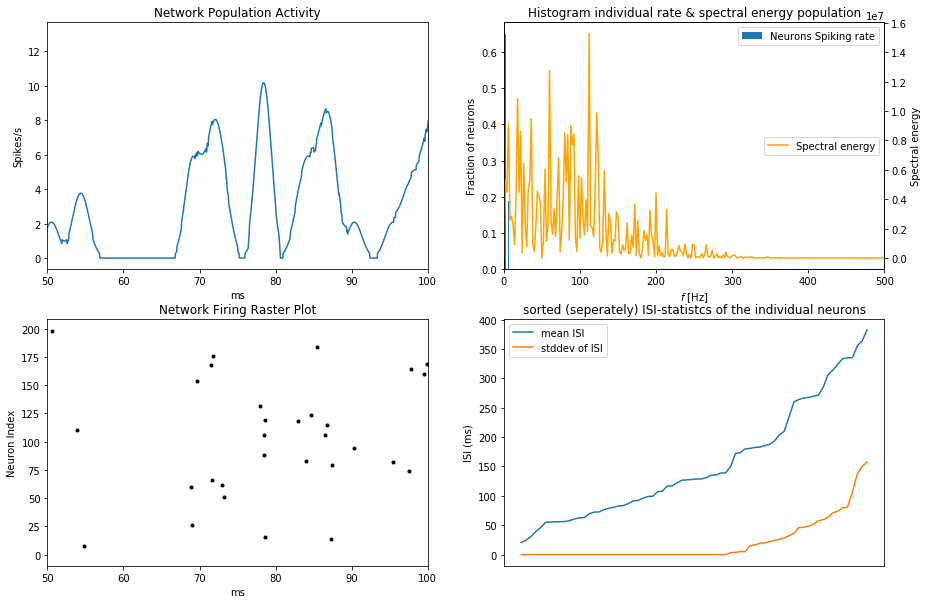

In [9]:
input_freq = 500
_,isi_array,_,_,_ = simulation_and_plots(input_freq, 500*ms);
cv = cvar(isi_array,input_freq,0)

Before v = -65. mV
After v = -62.58202695 mV


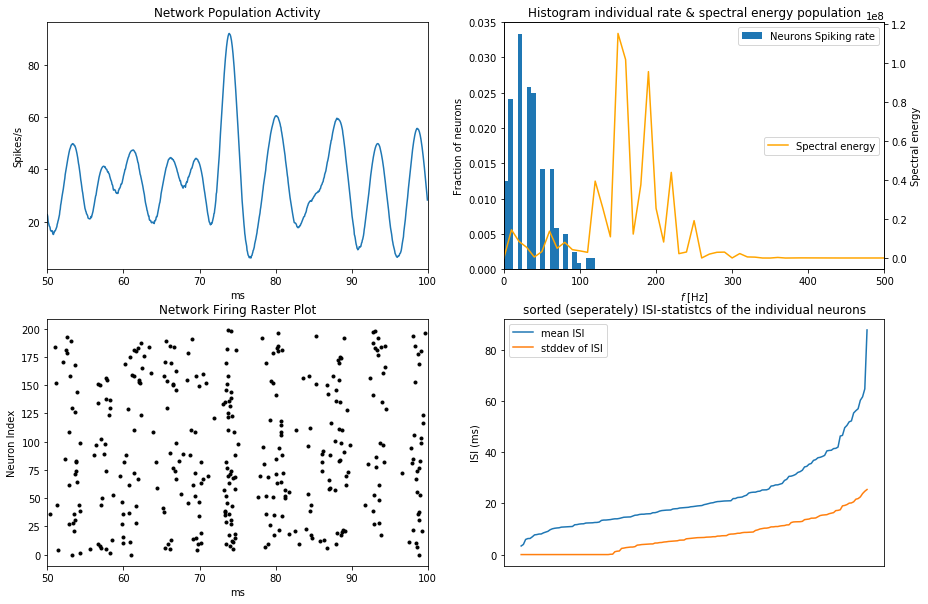

In [10]:
input_freq = 2000
_,isi_array,_,_,_ = simulation_and_plots(input_freq);
cv = np.vstack((cv,cvar(isi_array,input_freq,0)))

Before v = -65. mV
After v = -59.76381112 mV


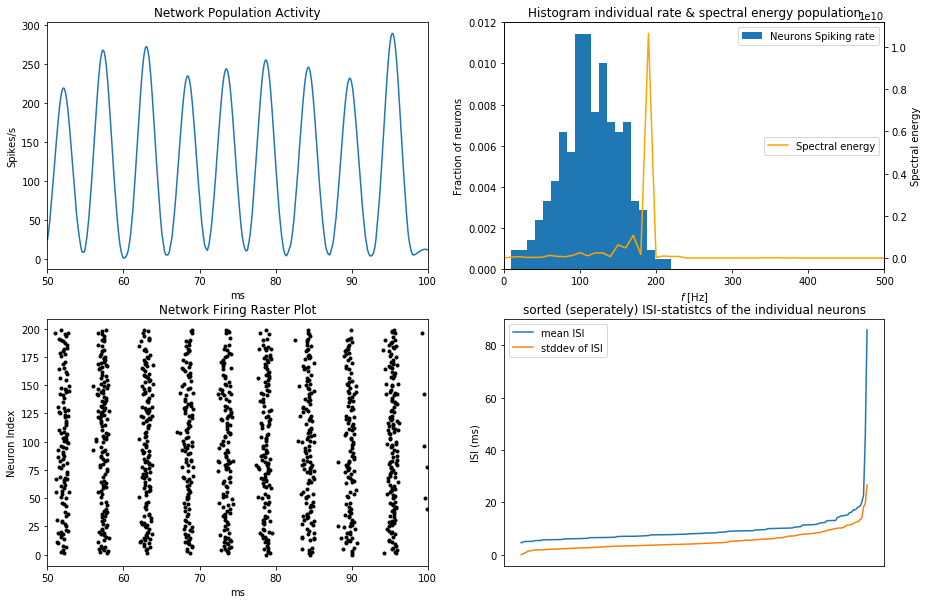

In [11]:
input_freq = 5000
_,isi_array,_,_,_ = simulation_and_plots(input_freq);
cv = np.vstack((cv,cvar(isi_array,input_freq,0)))

Okay, so already at 5 KHz input frequency we do observe a ~ 200 Hz oscillation in the network.(Actually even at 2 kHz but there the raster plot is pretty uncoherent).

Before v = -65. mV
After v = -61.09737034 mV


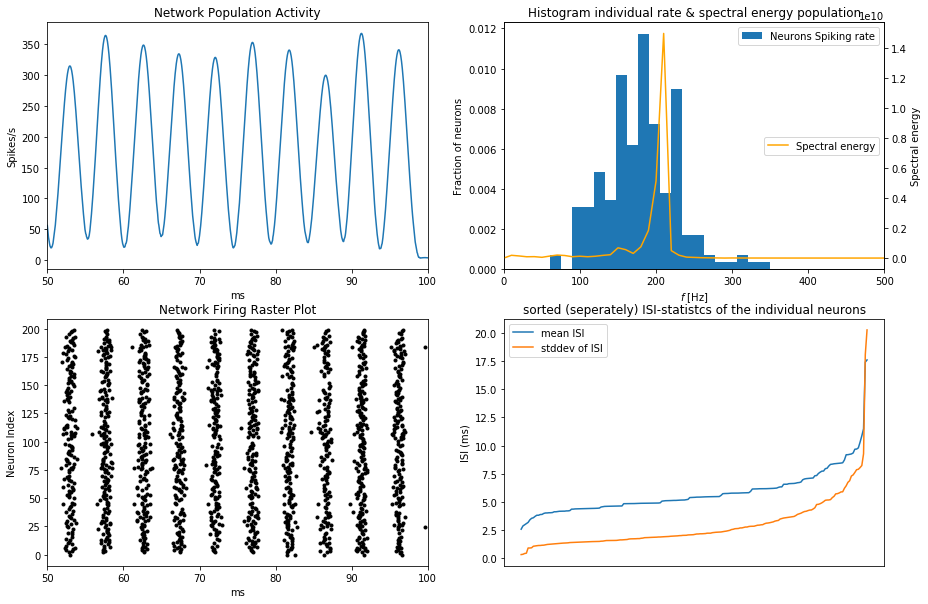

In [12]:
input_freq = 7500
_,isi_array,_,_,_ = simulation_and_plots(input_freq);
cv = np.vstack((cv,cvar(isi_array,input_freq,0)))

Before v = -65. mV
After v = -57.60969878 mV
Before v = -65. mV
After v = -52.78355892 mV


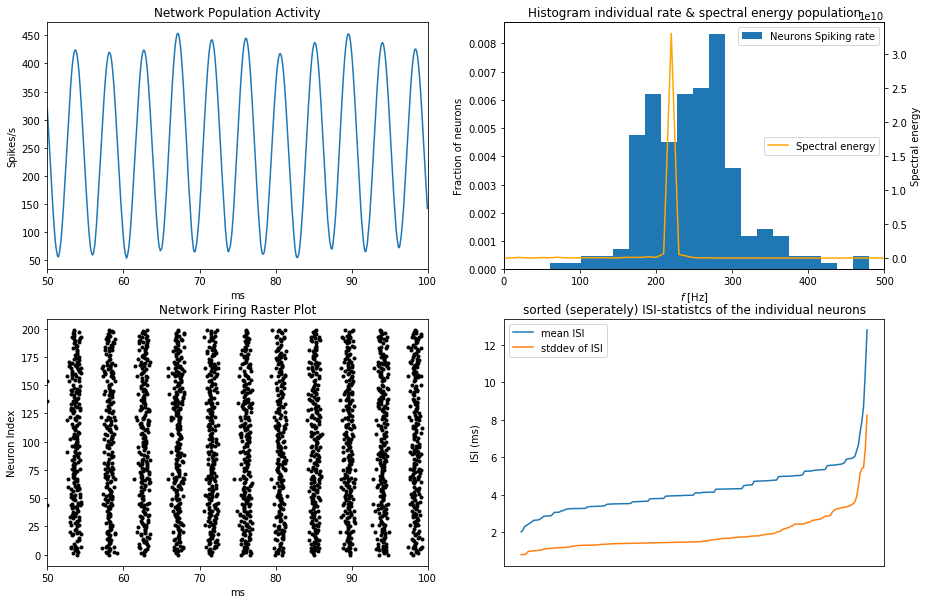

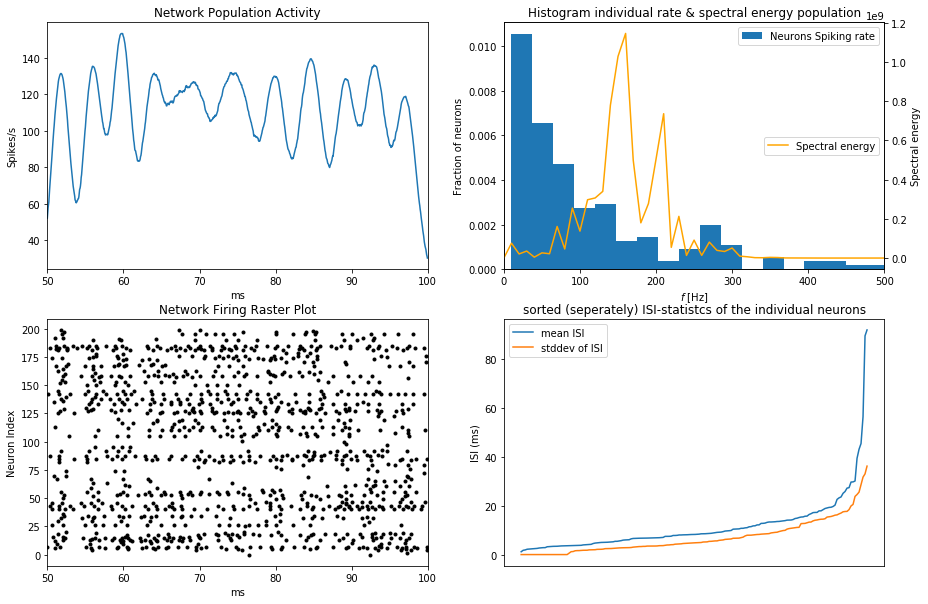

In [13]:
input_freq = 10000
Spike_Mon_10k, isi_array_10k, isi_means_10k, isi_std_10k, cv_10k = simulation_and_plots(input_freq);
Spike_Mon_G10k, isi_array_G10k, isi_means_G10k, isi_std_G10k, cv_G10k = simulation_and_plots(input_freq, tau_d_i=2*1.2*ms, g_peak_i=2*5*nS);

cv = np.vstack((cv,cvar(isi_array_10k,input_freq,0)))
cv = np.vstack((cv,cvar(isi_array_G10k,input_freq,1)))

Before v = -65. mV
After v = -54.90203407 mV


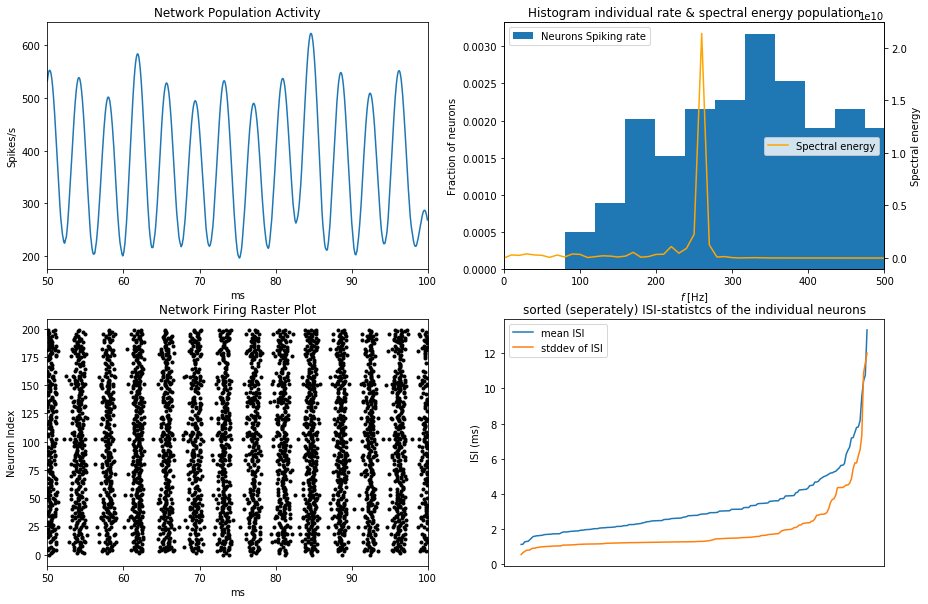

In [14]:
input_freq = 15000
_,isi_array,_,_,_ = simulation_and_plots(input_freq);
cv = np.vstack((cv,cvar(isi_array,input_freq,0)))

Before v = -65. mV
After v = -66.31696635 mV
Before v = -65. mV


WARNING    /Users/martin/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
 [py.warnings]
WARNING    /Users/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 [py.warnings]
WARNING    /Users/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
 [py.warnings]
WARNING    /Users/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
 [py.warnings]
WARNING    /Users/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 [py.warnings]


After v = -58.75960191 mV


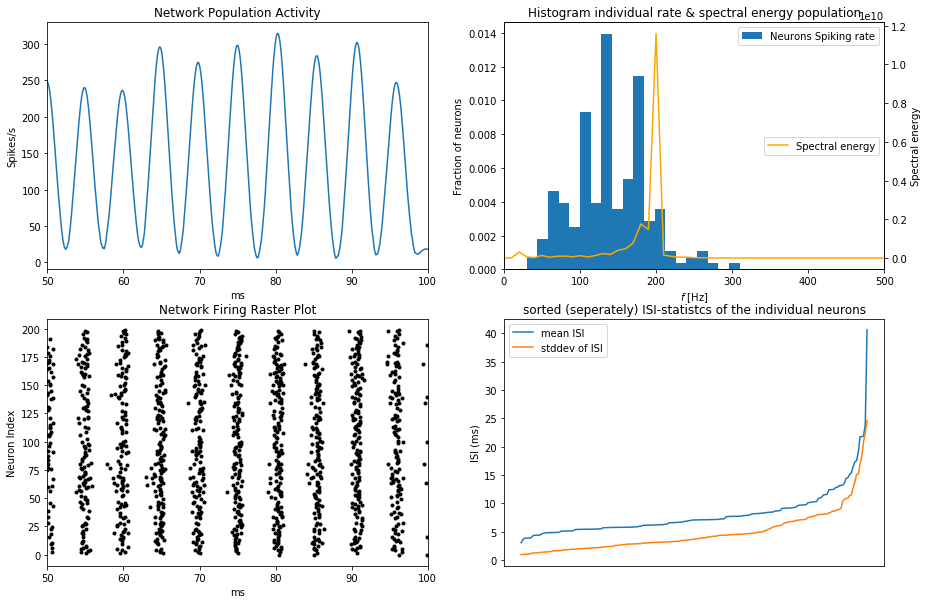

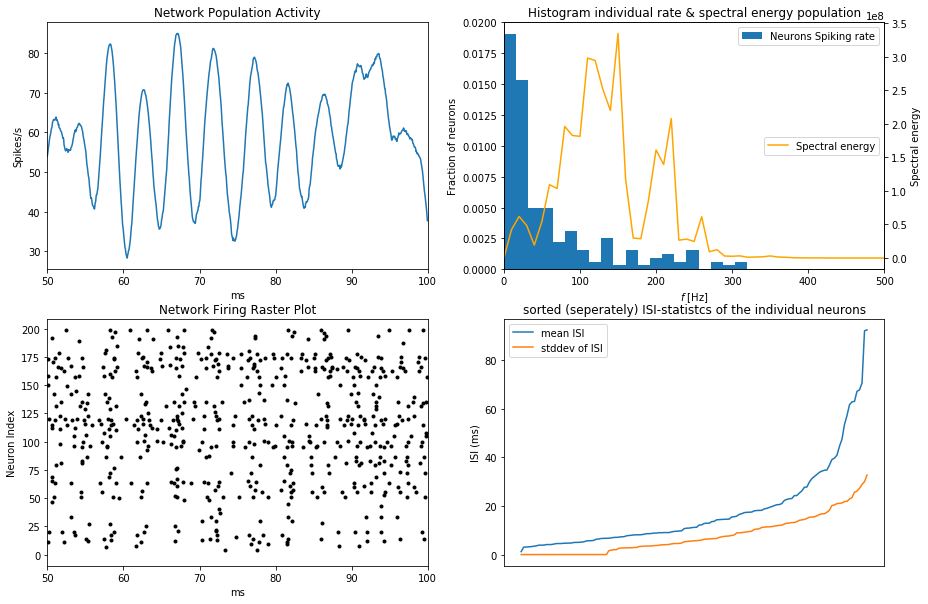

In [15]:
input_freq = 6000

_,isi_array_6k,_,_,_ = simulation_and_plots(input_freq);
_,isi_array_G6k,_,_,_ = simulation_and_plots(input_freq, tau_d_i=2*1.2*ms, g_peak_i=2*5*nS);

cv = np.vstack((cv,cvar(isi_array_6k,input_freq,0)))
cv = np.vstack((cv,cvar(isi_array_G6k,input_freq,1)))

Before v = -65. mV
After v = -59.14609256 mV
Before v = -65. mV
After v = -59.58936861 mV


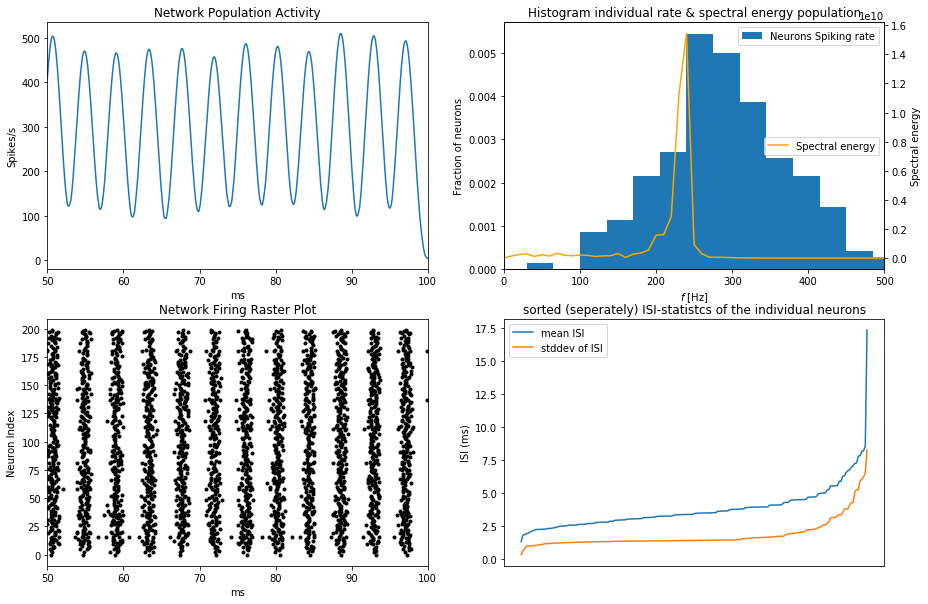

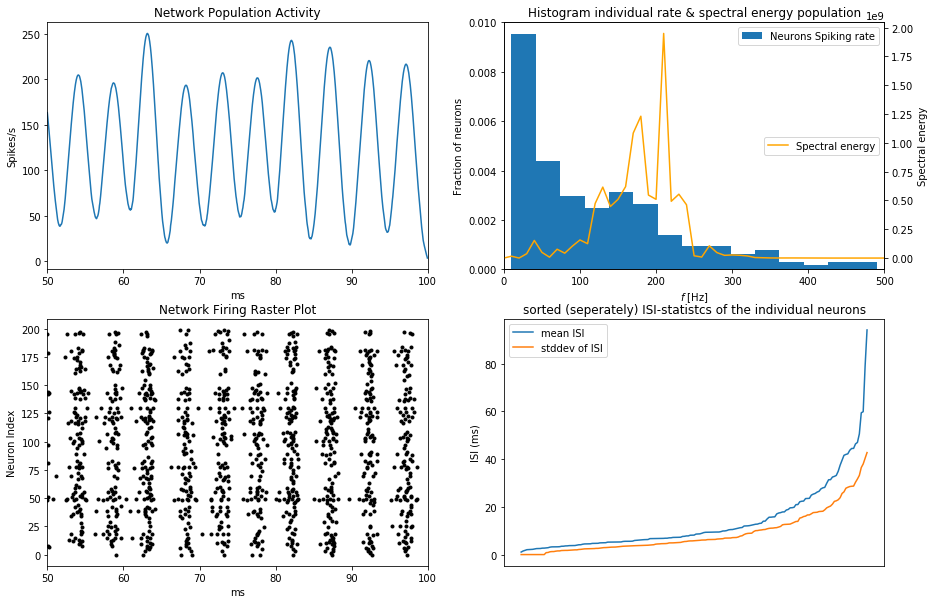

In [16]:
input_freq = 12000
Spike_Mon_12k, isi_array_12k, isi_means_12k, isi_std_12k, cv_12k = simulation_and_plots(input_freq);
Spike_Mon_G12k, isi_array_G12k, isi_means_G12k, isi_std_G12k, cv_G12k =simulation_and_plots(input_freq, tau_d_i=2*1.2*ms, g_peak_i=2*5*nS);


cv = np.vstack((cv,cvar(isi_array_12k,input_freq,0)))
cv = np.vstack((cv,cvar(isi_array_G12k,input_freq,1)))

# Some remarks
  We actually observe that the 200 Hz oscillation peak does not shift in frequency (apart from when the input frequency is 15 kHz.) However, we note the significant decrease in the power of that frequency in the spectral energy distribution. (Isn't this the same kinda result from the paper??)

# Inter Spike Interval and Variability 

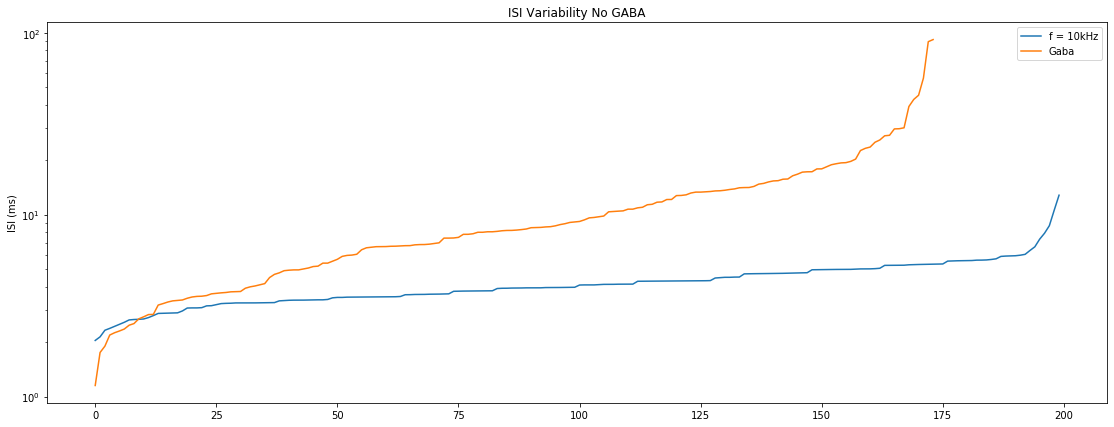

In [17]:
plt.rcParams['figure.figsize'] = (19,7)
#plt.errorbar(np.arange(len(isi_means)) , isi_means , yerr = isi_std, label = 'f = 10kHz')
plt.plot(np.sort(isi_means_10k), label = 'f = 10kHz')
plt.plot(np.sort(isi_means_G10k), label = 'Gaba')
plt.yscale('log')
#plt.xlabel('Neuron Index')
plt.ylabel('ISI (ms)')
plt.title('ISI Variability No GABA' )
plt.legend()
plt.show()

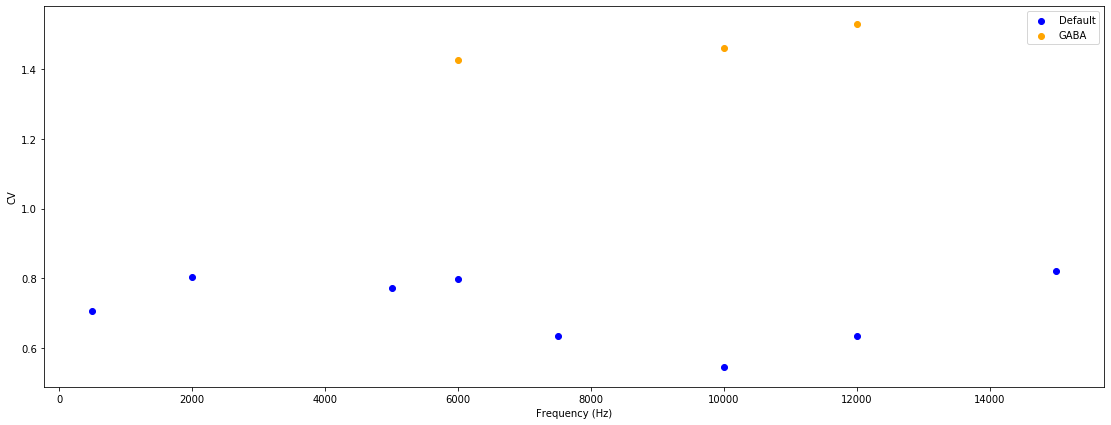

In [18]:
fig =plt.figure()
cv_gaba = cv[np.where(cv[:,2])].T
cv_def = cv[np.where(cv[:,2]==0)].T

plt.scatter(cv_def[:][1],cv_def[:][0],color='blue',label='Default')
plt.scatter(cv_gaba[:][1],cv_gaba[:][0],color='orange',label='GABA') 

plt.legend()
plt.xlabel('Frequency (Hz)');
plt.ylabel('CV');

# Some remarks
- From the ISI mean distribution, we definitely see a much more biologically and informationally relevant inter spike interval and also less variability in the ISIs. A mean ISI of ~ 5 ms could still imply tight coupling between neurons while ISIs on the order of 20 ms or so, with high standard deviation would more indicate random neuronal firings. This could be one of the metrics to characeterise the strength and type of the oscillation the network achieves. 